## Note:
For more details regarding the steps involved in this notebook, please refer to **(3.1) Model for Under_20.ipynb**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import numpy as np 
import pandas as pd

import io
import json
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
tokenizer = Tokenizer()

data = pd.read_csv('../../Data/sample2_2030.csv')
print("Number of sentences in the dataset:", data.shape[0])

corpus = data['0'].tolist()
random.shuffle(corpus)

# Tokenize the sentences
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print('There are %d unique words in total' %(total_words-1))

Number of sentences in the dataset: 5000
There are 11276 unique words in total


In [3]:
# Save tokenizer
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [7]:
input_sequences = []
for line in corpus: # iterate through the list of sentences
    # For each sentence, use the tokenizer to encode it into 
    # a sequence of numbers (word indices)
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    for i in range(1, len(token_list)): # iterate through the word 
                                        # indices of the sentence
        n_gram_sequence = token_list[:i+1] # create subset of the sentence
        input_sequences.append(n_gram_sequence)

# Determine the largest length of all sentences
max_sequence_len = max([len(x) for x in input_sequences]) 
print('The longest sentence has %d words' %max_sequence_len)

# Pad sequences (to the front)
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_sequence_len, padding='pre'))

# Create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# One-hot encode the labels (target output)
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

The longest sentence has 36 words


In [5]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.title(string + " changes over epochs")
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [6]:
def text_generator(seed_text, next_words, tokenizer, 
                   model, max_sequence_len):
    '''
    Returns a block of text generated using a trained model.
    
    Parameters:
        seed_text (str): several words to start the block of text
        next_words (int): number of generated words desired
        tokenizer: tokenizer of the trained model
        model: trained model for text generation
        max_sequence_len: the biggest length of the sentences fed to the model
    '''
    for w in range(next_words):
        # Tokenize the previous words (i.e. the starting words when the 
        # text generation first begins)
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad sequences
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, 
                                   padding='pre')
        # Generate model predictions based on the padded sequences
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            # Look for the corresponding word of the predicted word index 
            # output by the model above
            if index == predicted:
                output_word = word
                break
        # Add the predicted word
        seed_text += " " + output_word
    return seed_text

### Initial Round

In [9]:
xs, ys = prepare_data(tokenizer, corpus, max_sequence_len)

# Construct the model
model = Sequential()
model.add(Embedding(total_words, 150, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.15))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=['accuracy'])

filepath = "model_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

history = model.fit(xs, ys, epochs=30, batch_size=64, verbose=1, 
                    callbacks=desired_callbacks)

print(model)
print(model.summary())

Epoch 1/30
1234/1234 [==============================] - 38s 27ms/step - loss: 7.8431 - accuracy: 0.0381

Epoch 00001: loss improved from inf to 7.84311, saving model to model_weights.hdf5
Epoch 2/30
1234/1234 [==============================] - 33s 27ms/step - loss: 7.8441 - accuracy: 0.0593

Epoch 00002: loss did not improve from 7.84311
Epoch 3/30
1234/1234 [==============================] - 33s 27ms/step - loss: 7.4836 - accuracy: 0.0739

Epoch 00003: loss improved from 7.84311 to 7.48364, saving model to model_weights.hdf5
Epoch 4/30
1234/1234 [==============================] - 33s 27ms/step - loss: 7.1644 - accuracy: 0.0814

Epoch 00004: loss improved from 7.48364 to 7.16435, saving model to model_weights.hdf5
Epoch 5/30
1234/1234 [==============================] - 33s 27ms/step - loss: 7.0987 - accuracy: 0.0847

Epoch 00005: loss improved from 7.16435 to 7.09866, saving model to model_weights.hdf5
Epoch 6/30
1234/1234 [==============================] - 33s 27ms/step - loss: 7.0968

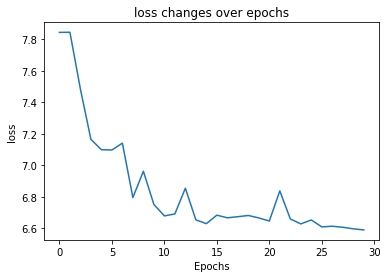

In [10]:
plot_graphs(history, 'loss')

The graph above shows that as the number of epoch increases, the training losses are declining with fluctuations. Towards epoch 30, the training losses have become more stable compared to earlier.

In [11]:
print(text_generator('i was home', 100, 
                     tokenizer, model, max_sequence_len))

i was home and i have a little injury side royce been completely si si hours of the hall of the hall of the hall of the hall of the hall of the hall of up address i was legitimate anonymous calculating reports stellastarr obligated up flip firsts obligated up dyke spoken emerged aka mysql blessed up hello obligated obligated obligated halfway eveyone adrian obligated up hello obligated up eveyone djing considering eveyone gaming buffy legitimate logical worries eveyone arbor aka eveyone eveyone 32 eveyone outfit i don�t chat somewhat flipping aka chris i was i added obligated obligated up eveyone dispirited ends


The text generated has shown some (although very little) sentence structure in the beginning. However, later on, some repetitions in phrases can be observed, and the model starts combining irrelevant words.

### After some tuning

In [12]:
# Construct the model
model = Sequential()
model.add(Embedding(total_words, 150, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=['accuracy'])

filepath = "model_weights2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

history = model.fit(xs, ys, epochs=25, batch_size=64, verbose=1, 
                    callbacks=desired_callbacks)

print(model)
print(model.summary())

Epoch 1/25
1234/1234 [==============================] - 27s 20ms/step - loss: 6.8270 - accuracy: 0.0772

Epoch 00001: loss improved from inf to 6.82696, saving model to model_weights2.hdf5
Epoch 2/25
1234/1234 [==============================] - 24s 20ms/step - loss: 5.9819 - accuracy: 0.12160s - loss: 5.9831 - accu

Epoch 00002: loss improved from 6.82696 to 5.98190, saving model to model_weights2.hdf5
Epoch 3/25
1234/1234 [==============================] - 25s 20ms/step - loss: 5.2766 - accuracy: 0.1497

Epoch 00003: loss improved from 5.98190 to 5.27664, saving model to model_weights2.hdf5
Epoch 4/25
1234/1234 [==============================] - 25s 20ms/step - loss: 4.4669 - accuracy: 0.1989

Epoch 00004: loss improved from 5.27664 to 4.46686, saving model to model_weights2.hdf5
Epoch 5/25
1234/1234 [==============================] - 26s 21ms/step - loss: 3.6810 - accuracy: 0.2820

Epoch 00005: loss improved from 4.46686 to 3.68097, saving model to model_weights2.hdf5
Epoch 6/25
1234

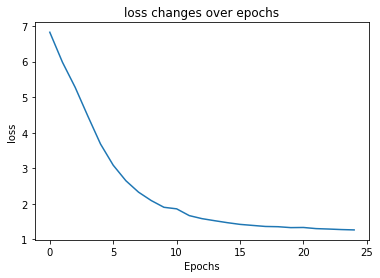

In [13]:
plot_graphs(history, 'loss')

The above graph shows that as the number of epoch increases, the training losses have been decreasing first rapidly then steadily. When it approaches 25 epochs, the losses are becoming stable.

In [14]:
print(text_generator('i was home', 100, 
                     tokenizer, model, max_sequence_len))

i was home now and when i was sitting at the dock the mall of sorrow without torment and most definitely change is conceived the bedrock of form of mine for a very long time i hated to meet up up evening ceremonies for both event based and continuous bioterrorism surveillance na lang palit ng indulgence eggs while atteint l’escalier de marbre un choc la paralysa ng kamikazee o selena i was thrilled up everyone beliefs it's night at beer yet again rks has taught me pegged a song on including unless the girl's mother goddess is the south shore expensive pictures of


Compared to the text generated before, the one output by the tuned model hasn't shown problems of repeating words. Moreover, some phrases can be observed in the block of text. However, it appears that the text doesn't make much sense as sentence structures are still missing.